# UC San Diego: Data Science in Practice - EDA Checkpoint
### Summer Session I 2023 | Instructor : C. Alex Simpkins Ph.D.

## Draft project title if you have one (can be changed later)

(This checkpoint helps you to perform your EDA on your data for your project. You can remove this text description. Consider this the next step in your final project. See the project readme for bullet points to check off in terms of details to include beyond the main section heading content below.)

# Names

- Conner Hsu
- Harshita Saha
- Sidharth Srinath
- Anastasiya Markova

<a id='research_question'></a>
# Research Question

Given clinical data for cohorts with and without diabetes, which feature most correlates to the measure of 'blood_glucose_level' for each cohort, and are they different between the cohorts?

# Setup

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
import seaborn as sns
from scipy import stats

In [41]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# Data Cleaning

Describe your data cleaning steps here.

In [42]:
# check if there is any missing data
df.isna().sum().sum()

0

In [43]:
# check the datatypes of each column
df.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

In [44]:
# checking gender of patients
df.groupby('gender').count()['age']

gender
Female    58552
Male      41430
Other        18
Name: age, dtype: int64

In [45]:
# removing records where gender is not specified/recorded as it may affect predictions
df = df[df['gender'] != 'Other']
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [46]:
# removing records for patients less than 20
# this is because the rates of diabetes are lower in these populations
# and diabetes is less well studied as a result, and analyis based 
# on these groups might not generalizable
# https://www.cdc.gov/diabetes/data/statistics-report/newly-diagnosed-diabetes.html
# https://diabetesjournals.org/care/article/46/3/490/148482/Youth-Onset-Type-2-Diabetes-The-Epidemiology-of-an
df = df[df['age'] >= 20]
df.shape

(80321, 9)

In [47]:
# bmi labeling
bmi_bins = pd.cut(df['bmi'], [0, 18.5, 25, 30, round(df['bmi'].max())], right=False, \
                  labels=['underweight', 'healthy', 'overweight', 'obese']) 
df['bmi_label'] = bmi_bins

/var/folders/p1/nnm56jzx5f36hgsqbgpnkr880000gn/T/ipykernel_82033/1588987266.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bmi_label'] = bmi_bins


In [48]:
# blood_glucose labeling
bg_bins = pd.cut(df['blood_glucose_level'], [0, 90, 130, round(df['blood_glucose_level'].max())], right=False, \
                 labels=['low', 'normal', 'high'])
df['bg_label'] = bg_bins

/var/folders/p1/nnm56jzx5f36hgsqbgpnkr880000gn/T/ipykernel_82033/3660563340.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bg_label'] = bg_bins


In [49]:
# HbA1c labeling
age_bins = pd.cut(df['age'], [19, 39, 59, round(df['age'].max())], labels=['g1', 'g2', 'g3'])
df['age_label'] = age_bins

#setting up thresholds for HbA1c levels
conditions = [df['age_label']=='g1', df['age_label']=='g2', df['age_label']=='g3']
choices = [6.0, 6.1, 6.5]
HbA1c_exp = np.select(conditions, choices)
df['HbA1c_label'] = HbA1c_exp

#assigning high/normal based on the thresholds and current HbA1c levels
df['HbA1c_label'] = (df['HbA1c_level'] <= df['HbA1c_label']).replace({True:'normal', False:'high'})
df.head()

/var/folders/p1/nnm56jzx5f36hgsqbgpnkr880000gn/T/ipykernel_82033/1006165652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_label'] = age_bins
/var/folders/p1/nnm56jzx5f36hgsqbgpnkr880000gn/T/ipykernel_82033/1006165652.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HbA1c_label'] = HbA1c_exp
/var/folders/p1/nnm56jzx5f36hgsqbgpnkr880000gn/T/ipykernel_82033/1006165652.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,bmi_label,bg_label,age_label,HbA1c_label
0,Female,80.0,0,1,never,25.19,6.6,140,0,overweight,high,g3,high
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,overweight,low,g2,high
2,Male,28.0,0,0,never,27.32,5.7,158,0,overweight,high,g1,normal
3,Female,36.0,0,0,current,23.45,5.0,155,0,healthy,high,g1,normal
4,Male,76.0,1,1,current,20.14,4.8,155,0,healthy,high,g3,normal


In [56]:
#reorderingthe columns
df = df[list(df.columns[:6])+['bmi_label', 'HbA1c_level', 'HbA1c_label', 'blood_glucose_level', 'bg_label', 'diabetes']]
#renaming the columns
df = df.rename(columns={"HbA1c_level": "hba1c", "HbA1c_label": "hba1c_label", "blood_glucose_level": "bg"})
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,bmi_label,hba1c,hba1c_label,bg,bg_label,diabetes
0,Female,80.0,0,1,never,25.19,overweight,6.6,high,140,high,0
1,Female,54.0,0,0,No Info,27.32,overweight,6.6,high,80,low,0
2,Male,28.0,0,0,never,27.32,overweight,5.7,normal,158,high,0
3,Female,36.0,0,0,current,23.45,healthy,5.0,normal,155,high,0
4,Male,76.0,1,1,current,20.14,healthy,4.8,normal,155,high,0


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

In [12]:
df.describe()

,age,hypertension,heart_disease,bmi,hba1c,bg,diabetes
count,80321.000000,80321.000000,80321.000000,80321.000000,80321.000000,80321.000000,80321.000000
mean,49.782946,0.093064,0.049003,28.711241,5.555272,139.280101,0.104506
std,17.478788,0.290524,0.215876,6.057741,1.090123,41.974772,0.305917
min,20.000000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,35.000000,0.000000,0.000000,25.700000,4.800000,100.000000,0.000000
50%,49.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,63.000000,0.000000,0.000000,30.750000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,91.820000,9.000000,300.000000,1.000000


In [13]:
# proportion of 'hypertension', 'heart_disease', 'diabetes' by gender
#df.groupby(['gender']).agg('mean')[['hypertension', 'heart_disease', 'diabetes']]
list(df.columns)

[('gender',),
 ('age',),
 ('hypertension',),
 ('heart_disease',),
 ('smoking_history',),
 ('bmi',),
 ('bmi_label',),
 ('hba1c',),
 ('hba1c_label',),
 ('bg',),
 ('bg_label',),
 ('diabetes',)]

In [14]:
df.dtypes

gender               object
age                 float64
hypertension          int64
heart_disease         int64
smoking_history      object
bmi                 float64
bmi_label          category
hba1c               float64
hba1c_label          object
bg                    int64
bg_label           category
diabetes              int64
dtype: object

<Axes: xlabel="('bmi',)", ylabel="('bg',)">

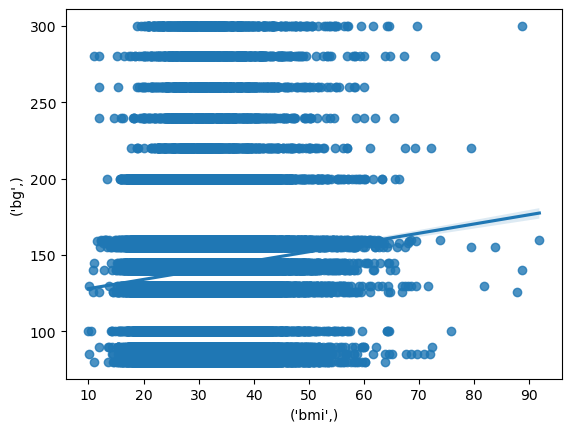

In [14]:
sns.regplot(x='bmi', y='bg', data=df)

<Axes: xlabel="('hba1c',)", ylabel="('bg',)">

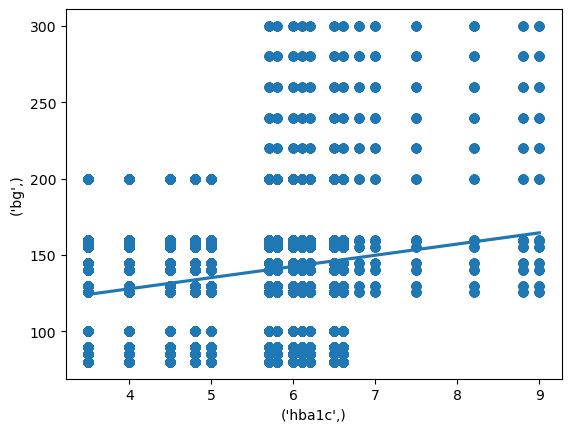

In [15]:
sns.regplot(x='hba1c', y='bg', data=df)

<Axes: xlabel="('age',)", ylabel="('bg',)">

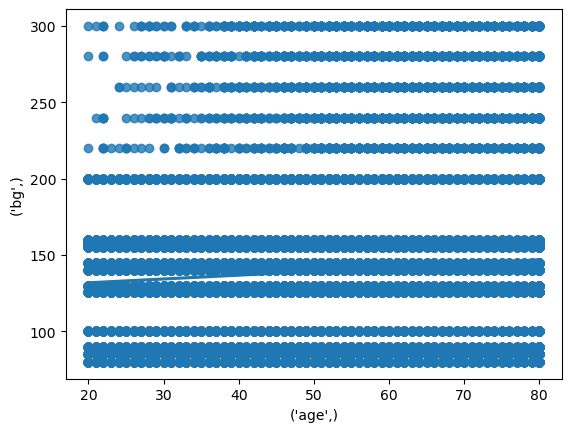

In [16]:
sns.regplot(x='age', y='bg', data=df)

## A/B Testing

#### Blood Glucose Levels

Null: The blood glucose levels of patients with and without diabetes have the same distribution

In [66]:
#df_observed = df.groupby(by='diabetes')#['bg', 'hba1c', 'bmi'].mean()
#df_observed
df_observed = df.groupby('diabetes')['bg', 'hba1c', 'bmi'].mean()

#difference in means
diffs = abs(df_observed.diff(axis=0))
diffs

/var/folders/p1/nnm56jzx5f36hgsqbgpnkr880000gn/T/ipykernel_82033/2378927800.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_observed = df.groupby('diabetes')['bg', 'hba1c', 'bmi'].mean()


,bg,hba1c,bmi
diabetes,,,
0,NaN,NaN,NaN
1,61.225135,1.539801,3.784757


<AxesSubplot:xlabel='bg', ylabel='Density'>

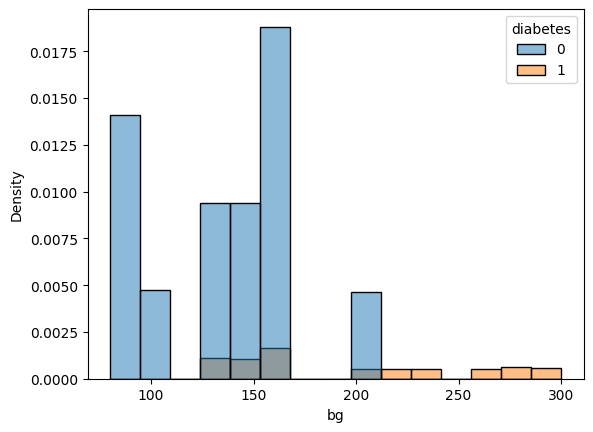

In [76]:
sns.histplot(x='bg', hue = 'diabetes', data=df, stat='density', kde=False, bins=15)

In [78]:
bg_observed = diffs.iloc[1,0]

61.2251347374646

In [ ]:
#permuations test
stats.permutation_test((df['diabetes'], df['bg']), )